In [ ]:
# ------------------------------
# 1. Import Libraries
# ------------------------------
import requests
from bs4 import BeautifulSoup
import nltk
from collections import defaultdict
from urllib.parse import urljoin, urlparse
import re

# ------------------------------
# 2. Stopwords Setup
# ------------------------------
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')
custom_STOPWORDS = []  # Add domain-specific stopwords if needed
STOPWORDS.extend(custom_STOPWORDS)

# ------------------------------
# 3. Data Structures
# ------------------------------
inverted_index = defaultdict(set)  # word -> set of URLs
url_list = set()
web_connection = {'source': [], 'target': []}  # link graph

# ------------------------------
# 4. Text Cleaning & Tokenization
# ------------------------------
def clean_and_tokenize(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())  # Remove punctuation, lowercase
    tokens = text.split()
    return [t for t in tokens if t not in STOPWORDS and len(t) > 1]

# ------------------------------
# 5. Crawling Function
# ------------------------------
def crawl(url, base_domain, visited, visit_limit, limit):
    if limit == 0 or len(visited) == visit_limit:
        return

    try:
        response = requests.get(url, timeout=5)
        if response.status_code != 200:
            return
    except requests.RequestException:
        return

    visited.add(url)
    print(f"Crawled: {url}")

    soup = BeautifulSoup(response.text, 'html.parser')
    text = soup.get_text(separator=' ', strip=True)
    words = clean_and_tokenize(text)

    for word in words:
        inverted_index[word].add(url)
        url_list.add(url)

    for tag in soup.find_all('a', href=True):
        link = urljoin(url, tag['href'])
        parsed = urlparse(link)

        web_connection['source'].append(url)
        web_connection['target'].append(link)

        if parsed.netloc == base_domain and link not in visited:
            crawl(link, base_domain, visited, visit_limit, limit - 1)

# ------------------------------
# 6. Root Crawling Function
# ------------------------------
def crawl_roots(root_urls, max_per_root=2, visit_limit=50):
    for root in root_urls:
        print(f"\nStarting crawl from: {root}")
        domain = urlparse(root).netloc
        visited = set()
        crawl(root, domain, visited, visit_limit, max_per_root)

# ------------------------------
# 7. Seed URLs (Domain-Specific)
# ------------------------------
seed_urls = [
    'https://www.bbc.com/news',
    'https://www.theguardian.com/world',
    # Add 8 to 18 more domain-specific URLs
]

# ------------------------------
# 8. Start Crawling
# ------------------------------
crawl_roots(seed_urls, max_per_root=5, visit_limit=50)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Starting crawl from: https://www.bbc.com/news
Crawled: https://www.bbc.com/news
Crawled: https://www.bbc.com/news#main-content
Crawled: https://www.bbc.com/watch-live-news/
Crawled: https://www.bbc.com/watch-live-news/#main-content
Crawled: https://www.bbc.com/
Crawled: https://www.bbc.com/sport
Crawled: https://www.bbc.com/business
Crawled: https://www.bbc.com/innovation
Crawled: https://www.bbc.com/culture
Crawled: https://www.bbc.com/arts
Crawled: https://www.bbc.com/travel
Crawled: https://www.bbc.com/future-planet
Crawled: https://www.bbc.com/audio
Crawled: https://www.bbc.com/video
Crawled: https://www.bbc.com/live
Crawled: https://www.bbc.com/home
Crawled: https://www.bbc.com/news/topics/c2vdnvdg6xxt
Crawled: https://www.bbc.com/news/war-in-ukraine
Crawled: https://www.bbc.com/news/us-canada
Crawled: https://www.bbc.com/news/uk
Crawled: https://www.bbc.com/news/politics
Crawled: https://www.bbc.com/news/england
Crawled: https://www.bbc.com/news/northern_ireland
Crawled: https:/

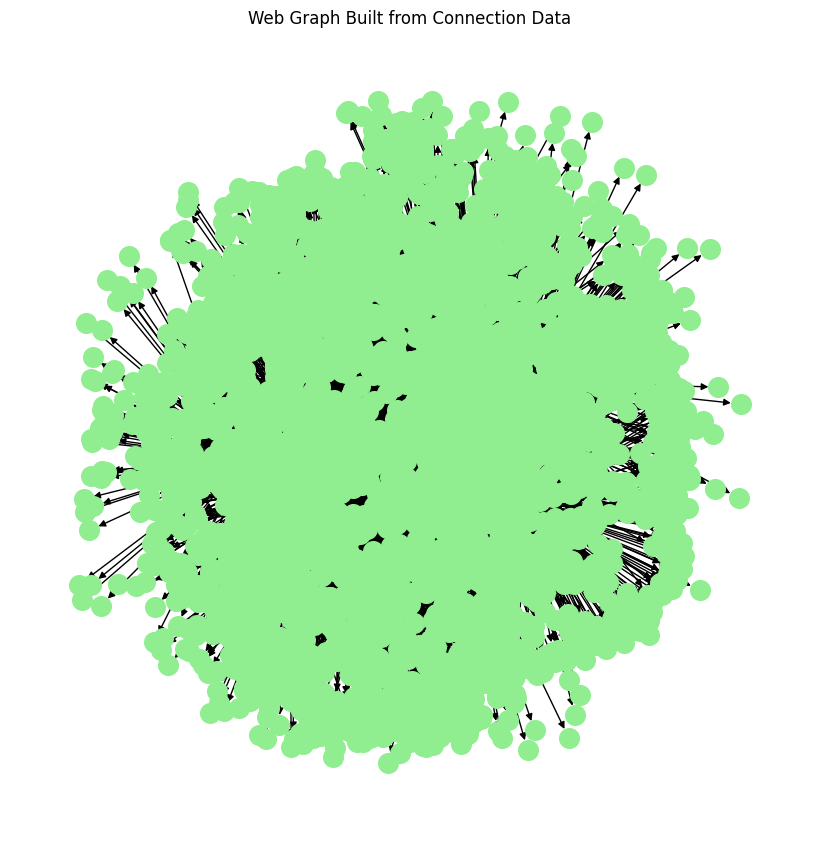


Search Results for 'politics' using PageRank:
https://www.bbc.com/culture (0.0004)
https://www.bbc.com/travel (0.0004)
https://www.bbc.com/news (0.0004)
https://www.bbc.com/news/world/asia (0.0004)
https://www.bbc.com/news/politics (0.0004)
https://www.bbc.com/culture/music (0.0004)
https://www.bbc.com/news/wales (0.0004)
https://www.bbc.com/news/northern_ireland (0.0004)
https://www.bbc.com/news/world/middle_east (0.0004)
https://www.bbc.com/news/england (0.0004)
https://www.bbc.com/news/uk (0.0004)
https://www.bbc.com/news/world/australia (0.0004)
https://www.bbc.com/news/bbcindepth (0.0004)
https://www.bbc.com/innovation (0.0004)
https://www.bbc.com/future-planet (0.0004)
https://www.bbc.com/video (0.0004)
https://www.bbc.com/audio (0.0004)
https://www.bbc.com/business (0.0004)
https://www.bbc.com/live (0.0004)
https://www.bbc.com/news/wales/wales_politics (0.0004)
https://www.bbc.com/innovation/artificial-intelligence (0.0004)
https://www.bbc.com/news/in_pictures (0.0004)
https://

In [ ]:
# ------------------------------
# 1. Libraries for Graph & Visualization
# ------------------------------
import networkx as nx
import matplotlib.pyplot as plt

# ------------------------------
# 2. Build Web Graph from web_connection Data
# ------------------------------
web_graph = nx.DiGraph()

# Loop through web_connection dictionary
for src, tgt in zip(web_connection['source'], web_connection['target']):
    web_graph.add_edge(src, tgt)

# ------------------------------
# 3. Visualize the Web Graph
# ------------------------------
plt.figure(figsize=(8, 8))
nx.draw(web_graph, with_labels=False, node_size=200, node_color="lightgreen", arrowsize=10)
plt.title("Web Graph Built from Connection Data")
plt.show()

# ------------------------------
# 4. Prepare Content for Each URL
# ------------------------------
web_content = {}
for url in url_list:
    content_words = [word for word in inverted_index if url in inverted_index[word]]
    web_content[url] = " ".join(content_words)

# ------------------------------
# 5. Apply Link Analysis Algorithms
# ------------------------------
hubs, authorities = nx.hits(web_graph, max_iter=100, tol=1e-6)
pagerank_scores = nx.pagerank(web_graph, alpha=0.85, max_iter=100, tol=1e-6)

# ------------------------------
# 6. Build Inverted Index for Search
# ------------------------------
from collections import defaultdict

def build_inverted_index(web_content):
    index = defaultdict(set)
    for website, content in web_content.items():
        words = content.lower().split()
        for word in words:
            index[word].add(website)
    return index

index = build_inverted_index(web_content)

# ------------------------------
# 7. Search Function with Ranking
# ------------------------------
def search_engine(query, index, scores):
    query_terms = query.lower().split()
    results = set()
    for term in query_terms:
        if term in index:
            if not results:
                results = index[term].copy()
            else:
                results = results.intersection(index[term])

    ranked_results = []
    for website in results:
        score = scores.get(website, 0)
        ranked_results.append((website, score))

    ranked_results.sort(key=lambda x: x[1], reverse=True)
    return ranked_results

# ------------------------------
# 8. Example Search Query
# ------------------------------
query = "politics"
print(f"\nSearch Results for '{query}' using PageRank:")
results = search_engine(query, index, pagerank_scores)
for page, score in results:
    print(f"{page} ({score:.4f})")

print(f"\nSearch Results for '{query}' using HITS (Authorities):")
results = search_engine(query, index, authorities)
for page, score in results:
    print(f"{page} ({score:.4f})")
